In [1]:
from Envs.pendulum import PendulumEnv
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

In [2]:
env = PendulumEnv()
env = TimeLimit(env, max_episode_steps=200) 

In [3]:
env.reset()

(array([-0.9434946, -0.3313878, -0.5660853], dtype=float32), {})

In [ ]:
from stable_baselines3 import PPO
import torch

In [ ]:
from MBEnvs.mb_pendulum2 import MB_PendulumEnv
env_models = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MB_env = MB_PendulumEnv(env_models, device)

In [ ]:
Global_RL = PPO("MlpPolicy", MB_env)

In [7]:
agent_sb3 = SB3Agent(policy_net=Global_RL)

NameError: name 'SB3Agent' is not defined

In [ ]:
test_client = FRLClient(env=env,agent=agent_sb3, lr=0.0001, hidden_size= 256, device=device)

In [ ]:
test_client.sample_data(100)

In [ ]:
test_client.dataset_X

In [ ]:
test_client.dataset_y

In [9]:
device

device(type='cuda')

In [1]:
from sb3_contrib import TRPO
from Client_diff import FRLClient
from Agent import SB3Agent
import copy
from stable_baselines3.common.evaluation import evaluate_policy
import torch

In [2]:
from Envs.pendulum import PendulumEnv
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from MBEnvs.mb_pendulum2 import MB_PendulumEnv

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# initialize the client and server
timesteps_real_per_round = 500
timesteps_fc_per_round = timesteps_real_per_round * 30
epoch_per_round = 100
CLIENTS_NUM = 3
rounds_num = 30
batch_size_env_model = 128

test_dir = "Diff_test2"
model_tmp_path = test_dir + "/models/tmp"

env_models = []
MB_env = TimeLimit(MB_PendulumEnv(env_models,device), max_episode_steps = 200)

# Global_RL = PPO("MlpPolicy", MB_env, verbose=1)
Global_RL = TRPO("MlpPolicy", MB_env, verbose=1)

env_theta = [0.1, 0.3, 0.5, 0.7, 0.9]
real_envs = []
Clients = []
for i in range(CLIENTS_NUM):
    real_envs.append( TimeLimit(PendulumEnv(), max_episode_steps=200) )
    policy_net = Global_RL
    agent = SB3Agent(policy_net)
    client = FRLClient(real_envs[i], agent, lr = 3e-4, hidden_size = 256, device = device)
    Clients.append(client)
    env_model = copy.deepcopy(client.model)
    env_models.append(env_model)
    

    
Global_RL.env.models = env_models

Global_RL.save(model_tmp_path)

rewards_log = []

env_models = []
for round_idx in range(rounds_num):
    print('------------------------------')
    print("round: " + str(round_idx))
    for client_idx in range(len(Clients)):
        print('------------------------------')
        print("client: " + str(client_idx))
        # update policy
        Clients[client_idx].agent.policy_net = Global_RL
        # train prediction models
        Clients[client_idx].learn(timesteps_real_per_round, epoch_per_round, batch_size_env_model)
        #
        env_model = Clients[client_idx].get_prediction_model()
        env_models.append(env_model)
    
#     Server.update_env_models(env_models)

    MB_env = TimeLimit(MB_PendulumEnv(env_models,device), max_episode_steps = 200)
    
    Global_RL = TRPO.load(model_tmp_path, env = MB_env)
#     Global_RL.env.models = env_models
    #
    Global_RL.learn(total_timesteps=timesteps_fc_per_round)
    
    Global_RL.save(model_tmp_path)
#     Server.learn(timesteps_real_per_round = 10000)
    # test performance
    mean_reward, std_reward = evaluate_policy(Global_RL, real_envs[1], n_eval_episodes=10)
    rewards_log.append(mean_reward)
    print("mean_reward in real env:" + str(mean_reward))
    
    

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------
round: 0
------------------------------
client: 0
Avg loss: 0.04868310136526512!
Avg loss: 0.044924415900022725!
Avg loss: 0.03592031486579799!
Avg loss: 0.028088284618218797!
Avg loss: 0.024023949964612257!
Avg loss: 0.01961558230448039!
Avg loss: 0.01582214093775595!
Avg loss: 0.0136429249152449!
Avg loss: 0.011391439223558942!
Avg loss: 0.010200884459894345!
Avg loss: 0.009813459757563881!
Avg loss: 0.00922204474969476!
Avg loss: 0.009200138067390071!
Avg loss: 0.009022898784041899!
Avg loss: 0.008806581991987817!
Avg loss: 0.008776119028402718!
Avg loss: 0.008708367624747856!
Avg loss: 0.008671851732908636!
Avg loss: 0.00859090020147202!
Avg loss: 0.008574432661339415!
Avg loss: 0.008541021096710514!
Avg loss: 0.008531650050093351!
Avg loss: 0.00853083459862925!
Avg loss: 0.00853476422660909!
Avg loss: 0.008525802299852028!
Avg loss: 0.008511673956184799!
Av

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.23e+03 |
| time/                     |           |
|    fps                    | 374       |
|    iterations             | 3         |
|    time_elapsed           | 16        |
|    total_timesteps        | 6144      |
| train/                    |           |
|    explained_variance     | 0.104     |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00585   |
|    learning_rate          | 0.001     |
|    n_updates              | 2         |
|    policy_objective       | 0.00286   |
|    std                    | 0.988     |
|    value_loss             | 8.24e+03  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.26e+03 |
| time/                     |     

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-970.8002081733197
------------------------------
round: 1
------------------------------
client: 0
Avg loss: 0.06627273318152826!
Avg loss: 0.06480540659918915!
Avg loss: 0.0708619611239313!
Avg loss: 0.06605237186638988!
Avg loss: 0.06447621269226754!
Avg loss: 0.06678620818939332!
Avg loss: 0.06697490413793275!
Avg loss: 0.06564920134653221!
Avg loss: 0.06538953432984423!
Avg loss: 0.06635129690348548!
Avg loss: 0.06594208235880311!
Avg loss: 0.06549720621177887!
Avg loss: 0.0658978603505481!
Avg loss: 0.06564643836732936!
Avg loss: 0.0656654613414139!
------------------------------
client: 1
Avg loss: 0.004166742545997598!
Avg loss: 0.002900009418456951!
Avg loss: 0.007681064587328971!
Avg loss: 0.0038525863432490345!
Avg loss: 0.002771797629654126!
Avg loss: 0.003844517233471076!
Avg loss: 0.00494996280194755!
Avg loss: 0.0029949685269093605!
Avg loss: 0.0028080201640477754!
Avg loss: 0.004186754163583828!
Avg loss: 0.003415331378976892!
Avg loss: 0.0027839

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1123.6436900161207
------------------------------
round: 2
------------------------------
client: 0
Avg loss: 0.04595727012188339!
Avg loss: 0.04513329592044708!
Avg loss: 0.04371459782497065!
Avg loss: 0.043524599199061716!
Avg loss: 0.04497609506921435!
Avg loss: 0.04373236365103367!
Avg loss: 0.0430247428365692!
Avg loss: 0.04279135617208643!
Avg loss: 0.043667421449763426!
Avg loss: 0.0434352506453079!
Avg loss: 0.04294429743931839!
Avg loss: 0.04314505370807789!
Avg loss: 0.04359112812998016!
Avg loss: 0.04321202044197283!
Avg loss: 0.043059611376550795!
Avg loss: 0.04324812638800836!
Avg loss: 0.04323747132383384!
Avg loss: 0.0430552755831953!
------------------------------
client: 1
Avg loss: 0.0033712965163916427!
Avg loss: 0.0030140623851427034!
Avg loss: 0.004273183082308!
Avg loss: 0.006035199996149459!
Avg loss: 0.002575412921808796!
Avg loss: 0.002218861856381409!
Avg loss: 0.003219299943278505!
Avg loss: 0.004272769116105337!
Avg loss: 0.002687604

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1136.0690905712545
------------------------------
round: 3
------------------------------
client: 0
Avg loss: 0.08860730226054632!
Avg loss: 0.0872106190736425!
Avg loss: 0.09186412328365501!
Avg loss: 0.08850939928113803!
Avg loss: 0.08807924521187184!
Avg loss: 0.08895508353252202!
Avg loss: 0.08935901745885834!
Avg loss: 0.08781970243418982!
Avg loss: 0.0880679602356031!
Avg loss: 0.08783331077774771!
Avg loss: 0.08726306064212622!
Avg loss: 0.08729015557394026!
------------------------------
client: 1
Avg loss: 0.023115810132197413!
Avg loss: 0.021476460115857965!
Avg loss: 0.022528968557683885!
Avg loss: 0.02572127637756542!
Avg loss: 0.025192270344947854!
Avg loss: 0.022284037851447162!
Avg loss: 0.022766560738840175!
Avg loss: 0.024529357165920373!
Avg loss: 0.025667055798664174!
Avg loss: 0.024594352347448875!
Avg loss: 0.023621905737333387!
Avg loss: 0.023823051412728093!
------------------------------
client: 2
Avg loss: 0.17691852111505188!
Avg loss:

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.01e+03 |
| time/                     |           |
|    fps                    | 350       |
|    iterations             | 7         |
|    time_elapsed           | 40        |
|    total_timesteps        | 14336     |
| train/                    |           |
|    explained_variance     | -1.1e-05  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00495   |
|    learning_rate          | 0.001     |
|    n_updates              | 30        |
|    policy_objective       | 0.00934   |
|    std                    | 0.774     |
|    value_loss             | 1.48e+03  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.02e+03 |
| time/                     |     

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1126.5493662536144
------------------------------
round: 4
------------------------------
client: 0
Avg loss: 0.009991101540642073!
Avg loss: 0.0023528850590658597!
Avg loss: 0.004359021072014002!
Avg loss: 0.008585107101098402!
Avg loss: 0.005926899896670269!
Avg loss: 0.0035123391749948495!
Avg loss: 0.0038919977982974766!
Avg loss: 0.006058044485798746!
Avg loss: 0.006198889290632602!
Avg loss: 0.004616945587101024!
Avg loss: 0.004219700316704499!
Avg loss: 0.0049035749223730815!
------------------------------
client: 1
Avg loss: 0.013727035904448712!
Avg loss: 0.013734596206377318!
Avg loss: 0.006057380173782197!
Avg loss: 0.004869298914957957!
Avg loss: 0.009247097374585185!
Avg loss: 0.005402114289014813!
Avg loss: 0.003244352648810794!
Avg loss: 0.0036176234932281657!
Avg loss: 0.005487214900519272!
Avg loss: 0.0033476310387747315!
Avg loss: 0.0027795328909572467!
Avg loss: 0.0037546656179983985!
Avg loss: 0.004120575644453008!
Avg loss: 0.00293429869671

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1142.3008359141647
------------------------------
round: 5
------------------------------
client: 0
Avg loss: 0.0499108149697228!
Avg loss: 0.04813748634031072!
Avg loss: 0.051862983946155815!
Avg loss: 0.04701341919346305!
Avg loss: 0.04825683764189307!
Avg loss: 0.0479135777943399!
Avg loss: 0.0481203679110331!
Avg loss: 0.046983335471437994!
Avg loss: 0.04791914197370109!
Avg loss: 0.04743778847231321!
Avg loss: 0.047343134480518835!
Avg loss: 0.04761655584172937!
Avg loss: 0.04727557324219257!
Avg loss: 0.04721976918111371!
Avg loss: 0.04732324165794125!
Avg loss: 0.0471144146883186!
Avg loss: 0.04711599996463822!
Avg loss: 0.04714602555027037!
------------------------------
client: 1
Avg loss: 0.1323634121505408!
Avg loss: 0.13192354168639212!
Avg loss: 0.14278564000395513!
Avg loss: 0.13551677178499327!
Avg loss: 0.13262570529914836!
Avg loss: 0.13303395645389704!
Avg loss: 0.13784535979907864!
Avg loss: 0.13378749619843197!
Avg loss: 0.13185960188051013!

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1095.7273782581092
------------------------------
round: 6
------------------------------
client: 0
Avg loss: 0.0050675059112836604!
Avg loss: 0.005986756579404755!
Avg loss: 0.003971439682451698!
Avg loss: 0.0029047839202879307!
Avg loss: 0.005543308122481297!
Avg loss: 0.0037737169814742325!
Avg loss: 0.0029607450207307312!
Avg loss: 0.0027131790677716104!
Avg loss: 0.0038297942307447858!
Avg loss: 0.0034663595476680104!
Avg loss: 0.002861779459429575!
Avg loss: 0.002890797284138292!
Avg loss: 0.003544277207329287!
Avg loss: 0.002974836674754139!
Avg loss: 0.0027579818621961748!
Avg loss: 0.002992909755130313!
Avg loss: 0.003136406140680871!
Avg loss: 0.002887586079329291!
------------------------------
client: 1
Avg loss: 0.010792828941678939!
Avg loss: 0.007445375104871346!
Avg loss: 0.007977934902301058!
Avg loss: 0.003695523758651689!
Avg loss: 0.003841831229995781!
Avg loss: 0.00491855194986177!
Avg loss: 0.00393740349016601!
Avg loss: 0.0037215578003088

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1022.6560384841636
------------------------------
round: 7
------------------------------
client: 0
Avg loss: 0.005259376554725653!
Avg loss: 0.003034152673280914!
Avg loss: 0.005268055121705402!
Avg loss: 0.0027004986609487484!
Avg loss: 0.0034987571225125673!
Avg loss: 0.0020378075984687407!
Avg loss: 0.003251292070975372!
Avg loss: 0.0021852122948682034!
Avg loss: 0.0025097840183661902!
Avg loss: 0.0022383992202230727!
Avg loss: 0.0024318222595259916!
Avg loss: 0.00210106112704428!
Avg loss: 0.002267907666634225!
Avg loss: 0.0022800786177352467!
Avg loss: 0.0021445172311238517!
Avg loss: 0.002236195196743438!
------------------------------
client: 1
Avg loss: 0.0030630467683658933!
Avg loss: 0.0024966324371416704!
Avg loss: 0.004897893477900653!
Avg loss: 0.004101042602487723!
Avg loss: 0.002013695229761652!
Avg loss: 0.0021178682658804368!
Avg loss: 0.003220096918069733!
Avg loss: 0.0031343683070736007!
Avg loss: 0.0023454766972099608!
Avg loss: 0.002446731

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1020.4520503315958
------------------------------
round: 8
------------------------------
client: 0
Avg loss: 0.17242476063751383!
Avg loss: 0.16829496057682264!
Avg loss: 0.17739168899463645!
Avg loss: 0.1732916169846673!
Avg loss: 0.16791130539689522!
Avg loss: 0.1682524582074287!
Avg loss: 0.17112923449099982!
Avg loss: 0.17106371217112004!
Avg loss: 0.16808926704564026!
Avg loss: 0.16874493147140887!
Avg loss: 0.170227430347821!
Avg loss: 0.17028857337156902!
Avg loss: 0.16919656020688612!
Avg loss: 0.1693425441270271!
Avg loss: 0.17006859540211886!
------------------------------
client: 1
Avg loss: 0.10890450232778676!
Avg loss: 0.09929357118421953!
Avg loss: 0.10243792172254568!
Avg loss: 0.10071307512972756!
Avg loss: 0.10213453028777925!
Avg loss: 0.09985272162291342!
Avg loss: 0.09958882458316415!
Avg loss: 0.10085328080031711!
Avg loss: 0.0997370120240521!
Avg loss: 0.0992850353111794!
Avg loss: 0.099267377435602!
Avg loss: 0.09998131395926672!
Avg lo

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1029.3009487275035
------------------------------
round: 9
------------------------------
client: 0
Avg loss: 0.2431542877231065!
Avg loss: 0.24000696286138312!
Avg loss: 0.23054179640896716!
Avg loss: 0.2339604713061999!
Avg loss: 0.2414405180605172!
Avg loss: 0.23375023199053732!
Avg loss: 0.23217269447801905!
Avg loss: 0.2371032289016633!
Avg loss: 0.23700928439518368!
Avg loss: 0.23308301002051546!
Avg loss: 0.23470196753581754!
Avg loss: 0.2368432907180492!
Avg loss: 0.2342056244334314!
------------------------------
client: 1
Avg loss: 0.11006164325150167!
Avg loss: 0.11432497401496221!
Avg loss: 0.12174957427237434!
Avg loss: 0.11213023792336116!
Avg loss: 0.11075206601145814!
Avg loss: 0.11677014032969359!
Avg loss: 0.11451520024737268!
Avg loss: 0.11053886185773384!
Avg loss: 0.11243682674483656!
Avg loss: 0.11543119225234628!
Avg loss: 0.1129111437556215!
------------------------------
client: 2
Avg loss: 0.05927252690986885!
Avg loss: 0.0530520281795

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-871.6724438581557
------------------------------
round: 10
------------------------------
client: 0
Avg loss: 0.05470757217437495!
Avg loss: 0.05627352830426995!
Avg loss: 0.05493397419227525!
Avg loss: 0.055231456938211826!
Avg loss: 0.05436321891545958!
Avg loss: 0.054955451802670724!
Avg loss: 0.053686688085351764!
Avg loss: 0.05393445657854803!
Avg loss: 0.05352991520293168!
Avg loss: 0.05368410542282921!
Avg loss: 0.0533523303852174!
Avg loss: 0.053116783270779705!
Avg loss: 0.05297077568979148!
Avg loss: 0.05288250386607312!
Avg loss: 0.05285149769768964!
Avg loss: 0.052773759373767465!
Avg loss: 0.05278365434099063!
Avg loss: 0.052731690818757976!
Avg loss: 0.05267730394404225!
Avg loss: 0.05260481536320034!
Avg loss: 0.05263871326355381!
Avg loss: 0.05274371925715457!
Avg loss: 0.052785305508058024!
Avg loss: 0.05273004563247544!
Avg loss: 0.05270445368809305!
Avg loss: 0.052688745575361885!
Avg loss: 0.05264217835047551!
Avg loss: 0.05261450193183407!


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-558.7193391416222
------------------------------
round: 11
------------------------------
client: 0
Avg loss: 0.03171844042449569!
Avg loss: 0.03233653821589542!
Avg loss: 0.031778455290962786!
Avg loss: 0.03160091962691998!
Avg loss: 0.031815146347325934!
Avg loss: 0.03185568731342452!
Avg loss: 0.031189510112092953!
Avg loss: 0.031044901121689086!
Avg loss: 0.030968582985507663!
Avg loss: 0.031034849760538538!
Avg loss: 0.030998594226227093!
Avg loss: 0.03091512646121752!
Avg loss: 0.030925324342624662!
Avg loss: 0.03091784794187182!
Avg loss: 0.030928885986010454!
Avg loss: 0.030902504377418913!
Avg loss: 0.0309297667228869!
Avg loss: 0.030906897726104034!
Avg loss: 0.030941323019898544!
Avg loss: 0.030943417796920586!
Avg loss: 0.03092819542995585!
Avg loss: 0.030895171535171358!
Avg loss: 0.03091109517496174!
Avg loss: 0.030991483801889975!
Avg loss: 0.030969561689513134!
Avg loss: 0.030946514039107267!
Avg loss: 0.030914157686595067!
Avg loss: 0.030981929

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-425.7675370226032
------------------------------
round: 12
------------------------------
client: 0
Avg loss: 0.006029936587243961!
Avg loss: 0.006606213541017496!
Avg loss: 0.00602817701847016!
Avg loss: 0.005859213543626538!
Avg loss: 0.005666340176788557!
Avg loss: 0.005672399624581885!
Avg loss: 0.0051766633602316385!
Avg loss: 0.005208948550040684!
Avg loss: 0.0050405655408466525!
Avg loss: 0.0051479638594173595!
Avg loss: 0.004982291946352764!
Avg loss: 0.005024522510242046!
Avg loss: 0.005042876985245736!
Avg loss: 0.005064151243860711!
Avg loss: 0.0049917583190237265!
Avg loss: 0.004990171153879525!
Avg loss: 0.005042669266667114!
Avg loss: 0.004996407382477628!
Avg loss: 0.004961487037876301!
Avg loss: 0.004961827056270446!
Avg loss: 0.0049757711763902535!
Avg loss: 0.00494702385116625!
Avg loss: 0.0049504965095400165!
Avg loss: 0.004982513747743553!
Avg loss: 0.004981047912656702!
Avg loss: 0.004948736253565945!
Avg loss: 0.004946616284246185!
Avg los

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -671     |
| time/                     |          |
|    fps                    | 349      |
|    iterations             | 8        |
|    time_elapsed           | 46       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.805    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00813  |
|    learning_rate          | 0.001    |
|    n_updates              | 103      |
|    policy_objective       | 0.0123   |
|    std                    | 0.468    |
|    value_loss             | 339      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-598.9239063396584
------------------------------
round: 13
------------------------------
client: 0
Avg loss: 0.0576486438789046!
Avg loss: 0.056496649980593554!
Avg loss: 0.059599923554703005!
Avg loss: 0.0562729809548182!
Avg loss: 0.056190321216636224!
Avg loss: 0.05802868409124737!
Avg loss: 0.05741444487530316!
Avg loss: 0.05694194873064286!
Avg loss: 0.05765271585797867!
Avg loss: 0.05792334515228201!
Avg loss: 0.05708575629039388!
Avg loss: 0.057375945720683226!
Avg loss: 0.05784478130168206!
Avg loss: 0.057414756780587294!
Avg loss: 0.057586207908676294!
------------------------------
client: 1
Avg loss: 0.050020242789008386!
Avg loss: 0.049039016879105474!
Avg loss: 0.051106410514342615!
Avg loss: 0.04915053181484837!
Avg loss: 0.04879624826959723!
Avg loss: 0.04946876815645737!
Avg loss: 0.04882593849173645!
Avg loss: 0.04846972497077938!
Avg loss: 0.04901704272076434!
Avg loss: 0.04861148911118714!
Avg loss: 0.048178348334022306!
Avg loss: 0.04846417

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -672     |
| time/                     |          |
|    fps                    | 336      |
|    iterations             | 8        |
|    time_elapsed           | 48       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.905    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00724  |
|    learning_rate          | 0.001    |
|    n_updates              | 111      |
|    policy_objective       | 0.0143   |
|    std                    | 0.42     |
|    value_loss             | 390      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-302.84364417297763
------------------------------
round: 14
------------------------------
client: 0
Avg loss: 0.0012395501258288277!
Avg loss: 0.0009243089108349523!
Avg loss: 0.0008211528571033948!
Avg loss: 0.0004726956392490441!
Avg loss: 0.0005926711946297777!
Avg loss: 0.0002741493294418736!
Avg loss: 0.000442388635072651!
Avg loss: 0.00030000717413334617!
Avg loss: 0.00023230156615075732!
Avg loss: 0.00028514068907194693!
Avg loss: 0.0002894905429805779!
Avg loss: 0.00022412827410638178!
Avg loss: 0.0002525897466633372!
Avg loss: 0.00024988979447925885!
Avg loss: 0.0002292181386565062!
Avg loss: 0.00023392308983905726!
Avg loss: 0.000239031942338291!
Avg loss: 0.00023234320774766579!
Avg loss: 0.00025138435063013273!
Avg loss: 0.00023980098861367576!
Avg loss: 0.0002585333948021192!
Avg loss: 0.0002561617785583318!
------------------------------
client: 1
Avg loss: 0.010318444714648649!
Avg loss: 0.007755491085942291!
Avg loss: 0.007196159024072888!
Avg 

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-242.57555727045983
------------------------------
round: 15
------------------------------
client: 0
Avg loss: 0.009467763165181775!
Avg loss: 0.009295442979606983!
Avg loss: 0.01006216572393896!
Avg loss: 0.00934494258111954!
Avg loss: 0.0093154845251604!
Avg loss: 0.009033788145282717!
Avg loss: 0.009288634823509103!
Avg loss: 0.009151149499592368!
Avg loss: 0.00899991035073981!
Avg loss: 0.008968307351206023!
Avg loss: 0.009080586555690691!
Avg loss: 0.009064556816906209!
Avg loss: 0.00892912208366018!
Avg loss: 0.008972881053581716!
Avg loss: 0.009016105660837942!
Avg loss: 0.008976195821985585!
Avg loss: 0.008941531594815236!
Avg loss: 0.00898713898507926!
Avg loss: 0.008980106598456813!
Avg loss: 0.008976101031893223!
Avg loss: 0.00894811925554753!
Avg loss: 0.009009853134315715!
Avg loss: 0.008958164897592269!
------------------------------
client: 1
Avg loss: 0.056381867405483115!
Avg loss: 0.05792903906841578!
Avg loss: 0.06342639703924458!
Avg loss: 0

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-255.74213915597647
------------------------------
round: 16
------------------------------
client: 0
Avg loss: 0.0005342572788746717!
Avg loss: 0.0003914373794638474!
Avg loss: 0.000623227530886652!
Avg loss: 0.00030464916818952285!
Avg loss: 0.0001697675089008044!
Avg loss: 0.00013658041999102958!
Avg loss: 0.0002489059001103063!
Avg loss: 0.00013807602580224434!
Avg loss: 9.559167803862085e-05!
Avg loss: 9.941362287463562e-05!
Avg loss: 0.00013180697761223806!
Avg loss: 0.00011449662534081047!
Avg loss: 8.817783618837893e-05!
Avg loss: 8.272505833247124e-05!
Avg loss: 0.00011364023923306377!
Avg loss: 9.400935488883987e-05!
Avg loss: 8.683277674208512e-05!
Avg loss: 9.77405029577009e-05!
Avg loss: 0.0001154545441265024!
Avg loss: 0.00010420959051164877!
Avg loss: 0.0001168599964967143!
Avg loss: 0.00013315616385322452!
Avg loss: 0.0001414430404201994!
Avg loss: 0.00014485078513340946!
------------------------------
client: 1
Avg loss: 0.0020197946448752193!
A

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-213.3483472181484
------------------------------
round: 17
------------------------------
client: 0
Avg loss: 0.0009592816106548223!
Avg loss: 0.0005348556831449968!
Avg loss: 0.0010814901388948783!
Avg loss: 0.0001340483874628262!
Avg loss: 0.0006935361847475481!
Avg loss: 0.00019352811896908406!
Avg loss: 0.0003690288961661281!
Avg loss: 0.00013586245240124602!
Avg loss: 0.00030422935993253!
Avg loss: 0.0001884503965023517!
Avg loss: 0.00017906445755215826!
Avg loss: 0.0001477353239920376!
Avg loss: 0.0001590086801797952!
Avg loss: 0.00017523388437742446!
------------------------------
client: 1
Avg loss: 0.009085256103426219!
Avg loss: 0.0077772840469454724!
Avg loss: 0.008119407220510766!
Avg loss: 0.00783724503412183!
Avg loss: 0.007626916047993291!
Avg loss: 0.007613458515479578!
Avg loss: 0.007470092679432128!
Avg loss: 0.007485278828098672!
Avg loss: 0.007359889777023151!
Avg loss: 0.007372903004206819!
Avg loss: 0.0074344692887590704!
Avg loss: 0.00734

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-283.1163841223344
------------------------------
round: 18
------------------------------
client: 0
Avg loss: 0.009837619023164735!
Avg loss: 0.009390264142023928!
Avg loss: 0.00945006859251104!
Avg loss: 0.009144264588079144!
Avg loss: 0.009228306288811534!
Avg loss: 0.00902597959187915!
Avg loss: 0.00904504217383116!
Avg loss: 0.008897471572563518!
Avg loss: 0.009006440931608116!
Avg loss: 0.00887800830118825!
Avg loss: 0.008923741781782155!
Avg loss: 0.008827276975847932!
Avg loss: 0.00886693775445167!
Avg loss: 0.008870706862570235!
Avg loss: 0.008837712606552183!
Avg loss: 0.008846405725466865!
Avg loss: 0.00886735729535379!
Avg loss: 0.008863759233591964!
Avg loss: 0.00885532449344737!
Avg loss: 0.008876971514003636!
Avg loss: 0.008878690206154167!
Avg loss: 0.008887065071547795!
------------------------------
client: 1
Avg loss: 0.0008579315689469998!
Avg loss: 0.0006765030923027856!
Avg loss: 0.0005308647405278559!
Avg loss: 0.00017006532993946166!
Avg 

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-186.7118948964402
------------------------------
round: 19
------------------------------
client: 0
Avg loss: 0.0006827760453961674!
Avg loss: 0.0005127654657796181!
Avg loss: 0.0005525034861057066!
Avg loss: 0.0003309338194655235!
Avg loss: 0.00024901291786591176!
Avg loss: 0.00018339166044218776!
Avg loss: 0.00020939700946958812!
Avg loss: 0.00013466414398749293!
Avg loss: 0.00012645685383783228!
Avg loss: 8.293033585497748e-05!
Avg loss: 0.00011506281497531745!
Avg loss: 8.267936333785049e-05!
Avg loss: 7.632523168164578e-05!
Avg loss: 7.540206504017987e-05!
Avg loss: 6.598923677434717e-05!
Avg loss: 6.972853323380453e-05!
Avg loss: 7.257131753969286e-05!
Avg loss: 6.496420665134413e-05!
Avg loss: 6.059329261044392e-05!
Avg loss: 6.700146546412119e-05!
Avg loss: 6.747115483809314e-05!
Avg loss: 6.411635845608999e-05!
Avg loss: 6.522266504229416e-05!
Avg loss: 6.95935707393384e-05!
Avg loss: 6.42324798199212e-05!
Avg loss: 6.376605067468214e-05!
Avg loss: 6.4

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-239.12449115570635
------------------------------
round: 20
------------------------------
client: 0
Avg loss: 0.0012593470286810771!
Avg loss: 0.001284285746999861!
Avg loss: 0.0019233152052440042!
Avg loss: 0.001831849644271036!
Avg loss: 0.0020667007787786434!
Avg loss: 0.0023099389531853376!
Avg loss: 0.0021216586681415115!
Avg loss: 0.002141524536430855!
Avg loss: 0.002177024127437524!
Avg loss: 0.002355209077783608!
Avg loss: 0.002423244958445139!
------------------------------
client: 1
Avg loss: 0.011370689129228898!
Avg loss: 0.011024068804981652!
Avg loss: 0.011629930553463055!
Avg loss: 0.0110530469519108!
Avg loss: 0.010993630656375899!
Avg loss: 0.010863633202928517!
Avg loss: 0.011148461288794351!
Avg loss: 0.011000597860487082!
Avg loss: 0.010887224484674031!
Avg loss: 0.010833187454813924!
Avg loss: 0.010978165596326714!
Avg loss: 0.010945251265582859!
Avg loss: 0.010869910649741238!
Avg loss: 0.010869218464558609!
Avg loss: 0.010922988945249774

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-367.1023692952469
------------------------------
round: 21
------------------------------
client: 0
Avg loss: 0.013616718595537047!
Avg loss: 0.012849573697464317!
Avg loss: 0.012974325368995778!
Avg loss: 0.012552570795479218!
Avg loss: 0.01243400377928386!
Avg loss: 0.012646986913847892!
Avg loss: 0.012480408243087973!
Avg loss: 0.012312043280059394!
Avg loss: 0.012400528900089587!
Avg loss: 0.012428872903025573!
Avg loss: 0.012233647825041013!
Avg loss: 0.012251676954679169!
Avg loss: 0.012344408623306057!
Avg loss: 0.012261133748370708!
Avg loss: 0.01224930631964071!
Avg loss: 0.012293844724736876!
Avg loss: 0.01229408998276881!
Avg loss: 0.0122486181135226!
Avg loss: 0.012276097905973605!
Avg loss: 0.012285716623280223!
Avg loss: 0.012255893931069673!
------------------------------
client: 1
Avg loss: 0.00042808294771627214!
Avg loss: 0.00029260829051054317!
Avg loss: 0.0002887552871106891!
Avg loss: 0.00015006471969779037!
Avg loss: 0.00013226945297598527

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-156.5617831733078
------------------------------
round: 22
------------------------------
client: 0
Avg loss: 0.0005700017351773567!
Avg loss: 0.00027473044150004474!
Avg loss: 0.0003716496814740822!
Avg loss: 9.722042843653374e-05!
Avg loss: 0.00024394063591898885!
Avg loss: 0.00010865774277287225!
Avg loss: 7.396960076221149e-05!
Avg loss: 9.043582350689879e-05!
Avg loss: 6.388803883358681e-05!
Avg loss: 7.904545188163563e-05!
Avg loss: 4.806483079543492e-05!
Avg loss: 5.617593991360081e-05!
Avg loss: 6.120945078691876e-05!
Avg loss: 4.47615665580751e-05!
Avg loss: 5.023613031956605e-05!
Avg loss: 4.431422870671516e-05!
Avg loss: 5.435989225740438e-05!
Avg loss: 4.5843707919933274e-05!
Avg loss: 4.659274479990927e-05!
Avg loss: 4.9963289855744125e-05!
Avg loss: 4.913883177058172e-05!
Avg loss: 4.830137938218589e-05!
Avg loss: 4.5690519778910733e-05!
Avg loss: 5.1968120939515456e-05!
Avg loss: 4.739112780934344e-05!
Avg loss: 4.939026969244272e-05!
-----------

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-167.36910062208773
------------------------------
round: 23
------------------------------
client: 0
Avg loss: 0.0010162702998301636!
Avg loss: 0.0006377777152132088!
Avg loss: 0.0004967193757450635!
Avg loss: 0.0003056873350093762!
Avg loss: 0.0003320280300158629!
Avg loss: 0.0004278472886168553!
Avg loss: 0.00022110874140404728!
Avg loss: 0.0001828742255687151!
Avg loss: 0.0002905333302836273!
Avg loss: 0.00023266911176657838!
Avg loss: 0.00017022010876795927!
Avg loss: 0.00019709974634679383!
Avg loss: 0.00019986270188004104!
Avg loss: 0.0001780910848841207!
Avg loss: 0.00015713419671328665!
Avg loss: 0.00016129426734740567!
Avg loss: 0.0001851680784720126!
Avg loss: 0.00017451039392123372!
Avg loss: 0.00015632885060843667!
Avg loss: 0.00016630837397618354!
Avg loss: 0.0001843087036130934!
Avg loss: 0.00017188532408795253!
Avg loss: 0.00017079189575573158!
Avg loss: 0.00017773430896302975!
Avg loss: 0.00017193377380882188!
Avg loss: 0.00017034732061328364!
A

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -506     |
| time/                     |          |
|    fps                    | 351      |
|    iterations             | 7        |
|    time_elapsed           | 40       |
|    total_timesteps        | 14336    |
| train/                    |          |
|    explained_variance     | 0.801    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00904  |
|    learning_rate          | 0.001    |
|    n_updates              | 190      |
|    policy_objective       | 0.0168   |
|    std                    | 0.306    |
|    value_loss             | 391      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -524     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-208.07899495717137
------------------------------
round: 24
------------------------------
client: 0
Avg loss: 0.00047301665089131956!
Avg loss: 0.0003889250762373801!
Avg loss: 0.0002326191657690894!
Avg loss: 0.0003451362390903038!
Avg loss: 0.00014674799586524993!
Avg loss: 0.00020041597055808324!
Avg loss: 0.00013431266346439468!
Avg loss: 0.00011280497554423619!
Avg loss: 8.675302737894223e-05!
Avg loss: 0.00011979030562846068!
Avg loss: 9.70159229118887e-05!
Avg loss: 9.653846936525194e-05!
Avg loss: 9.954734466039857e-05!
Avg loss: 0.00010690682023512939!
Avg loss: 9.590354813402276e-05!
Avg loss: 9.019833717028784e-05!
Avg loss: 8.641273052338268e-05!
Avg loss: 9.307418642417057e-05!
Avg loss: 8.611196338665176e-05!
Avg loss: 8.25924228979602e-05!
Avg loss: 8.34857828508954e-05!
Avg loss: 8.50084383741508e-05!
Avg loss: 8.372569205221225e-05!
Avg loss: 8.379903501122499e-05!
Avg loss: 8.398196351805609e-05!
Avg loss: 8.270962432372168e-05!
Avg loss: 8.2

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -525     |
| time/                     |          |
|    fps                    | 320      |
|    iterations             | 8        |
|    time_elapsed           | 51       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.826    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00636  |
|    learning_rate          | 0.001    |
|    n_updates              | 199      |
|    policy_objective       | 0.014    |
|    std                    | 0.281    |
|    value_loss             | 427      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-143.8481327002868
------------------------------
round: 25
------------------------------
client: 0
Avg loss: 0.005908909195907957!
Avg loss: 0.005430002030423869!
Avg loss: 0.005719002043939933!
Avg loss: 0.005556549241749357!
Avg loss: 0.005368652816371953!
Avg loss: 0.005319093389516638!
Avg loss: 0.005398368289907012!
Avg loss: 0.00539402518541768!
Avg loss: 0.005282351113179781!
Avg loss: 0.005294852340261969!
Avg loss: 0.005298494402503214!
Avg loss: 0.0053278290950947845!
Avg loss: 0.005261098418272923!
Avg loss: 0.005273917081525876!
Avg loss: 0.005286963045848931!
Avg loss: 0.005292854243843029!
Avg loss: 0.005264514653252566!
Avg loss: 0.005276624655067839!
Avg loss: 0.005287719797369922!
Avg loss: 0.005282870534093338!
Avg loss: 0.0052693444410906905!
Avg loss: 0.005284515929914069!
Avg loss: 0.0052844855990764475!
------------------------------
client: 1
Avg loss: 0.0006451421937284371!
Avg loss: 0.0003567326751362998!
Avg loss: 0.000358679170518977

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-150.1074405770749
------------------------------
round: 26
------------------------------
client: 0
Avg loss: 0.004430670024400267!
Avg loss: 0.004231968593327717!
Avg loss: 0.004093725683687808!
Avg loss: 0.003976156569588056!
Avg loss: 0.004112066220962636!
Avg loss: 0.004008704366236391!
Avg loss: 0.003906768337546964!
Avg loss: 0.003933574032459243!
Avg loss: 0.003950298575167229!
Avg loss: 0.003901899562234803!
Avg loss: 0.0039099125743086915!
Avg loss: 0.003944531478612514!
Avg loss: 0.003899835031023334!
Avg loss: 0.003895958346350407!
Avg loss: 0.003924339416296476!
Avg loss: 0.003915925677033556!
Avg loss: 0.0039010701471419414!
Avg loss: 0.0039010170268329604!
Avg loss: 0.003912727897406967!
Avg loss: 0.003895068207013234!
Avg loss: 0.0038935045657855958!
Avg loss: 0.0039037543494278757!
Avg loss: 0.0038935085618322773!
Avg loss: 0.0038963116050164596!
Avg loss: 0.0039061352913650656!
Avg loss: 0.0038971270979726567!
Avg loss: 0.00390123829320828!
Avg

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -411     |
| time/                     |          |
|    fps                    | 355      |
|    iterations             | 8        |
|    time_elapsed           | 46       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.905    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0089   |
|    learning_rate          | 0.001    |
|    n_updates              | 215      |
|    policy_objective       | 0.0204   |
|    std                    | 0.229    |
|    value_loss             | 377      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-200.99566091261804
------------------------------
round: 27
------------------------------
client: 0
Avg loss: 0.0034791638871926505!
Avg loss: 0.0030569279869208307!
Avg loss: 0.0030235938920426027!
Avg loss: 0.00279048275050324!
Avg loss: 0.0030557790742022917!
Avg loss: 0.0028210134887558524!
Avg loss: 0.002768905947353536!
Avg loss: 0.002728878123657523!
Avg loss: 0.002877984941909138!
Avg loss: 0.0027636868993219346!
Avg loss: 0.0027235257469268013!
Avg loss: 0.0027436307714613878!
Avg loss: 0.0027785756624136107!
Avg loss: 0.0027260111169039192!
Avg loss: 0.002732045839350879!
Avg loss: 0.0027410066884021944!
Avg loss: 0.0027491969307709497!
Avg loss: 0.0027314694022298153!
Avg loss: 0.0027250153811833873!
Avg loss: 0.0027461022293778113!
Avg loss: 0.0027377404011613747!
------------------------------
client: 1
Avg loss: 0.000505386282748077!
Avg loss: 0.0004303324038119172!
Avg loss: 0.0003398156560918627!
Avg loss: 0.0001591254129925801!
Avg loss: 0.000

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -502     |
| time/                     |          |
|    fps                    | 338      |
|    iterations             | 8        |
|    time_elapsed           | 48       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.904    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00953  |
|    learning_rate          | 0.001    |
|    n_updates              | 223      |
|    policy_objective       | 0.0223   |
|    std                    | 0.228    |
|    value_loss             | 490      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-209.2300049532205
------------------------------
round: 28
------------------------------
client: 0
Avg loss: 0.0005128015870286617!
Avg loss: 0.0002809878995321924!
Avg loss: 0.00036378466742462476!
Avg loss: 0.00019660279715026264!
Avg loss: 0.0001077881428955152!
Avg loss: 0.0001705930738777776!
Avg loss: 8.59240582296176e-05!
Avg loss: 6.829729115755374e-05!
Avg loss: 7.144387413063669e-05!
Avg loss: 8.739094490541295e-05!
Avg loss: 6.589114760951513e-05!
Avg loss: 4.6391348970473704e-05!
Avg loss: 6.640445810338255e-05!
Avg loss: 5.1463538273613573e-05!
Avg loss: 5.336189447386156e-05!
Avg loss: 6.10930129758458e-05!
Avg loss: 4.4978623962682224e-05!
Avg loss: 5.027264706010707e-05!
Avg loss: 5.473923272016161e-05!
Avg loss: 4.9472837616425144e-05!
Avg loss: 4.550044163579514e-05!
Avg loss: 5.113265678839222e-05!
Avg loss: 5.1188462051262226e-05!
Avg loss: 4.843920023669549e-05!
Avg loss: 4.9804226130921354e-05!
Avg loss: 4.940082065104434e-05!
Avg loss: 4

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-172.16850874321534
------------------------------
round: 29
------------------------------
client: 0
Avg loss: 0.0007050160969568727!
Avg loss: 0.0005505656792471806!
Avg loss: 0.0002794464791986684!
Avg loss: 0.00014617742841162832!
Avg loss: 0.0003789550148940179!
Avg loss: 0.00010512208301709809!
Avg loss: 0.00013487358716398983!
Avg loss: 0.0001874356892327948!
Avg loss: 0.00022140460221028963!
Avg loss: 7.245931806513302e-05!
Avg loss: 6.849372019132716e-05!
Avg loss: 0.00015369844194234854!
Avg loss: 0.00015381337055562957!
Avg loss: 9.153713861148087e-05!
Avg loss: 9.404157238047143e-05!
Avg loss: 0.00012658181150773846!
Avg loss: 0.00010373000273527092!
Avg loss: 0.00010332194935775381!
Avg loss: 0.00012240393310283555!
Avg loss: 0.00010644035447209414!
Avg loss: 9.609135183685187e-05!
------------------------------
client: 1
Avg loss: 0.0005789828415921268!
Avg loss: 0.0004655961410996194!
Avg loss: 0.0003016796289011836!
Avg loss: 0.000154081628371992

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -494     |
| time/                     |          |
|    fps                    | 361      |
|    iterations             | 8        |
|    time_elapsed           | 45       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.903    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0092   |
|    learning_rate          | 0.001    |
|    n_updates              | 239      |
|    policy_objective       | 0.0233   |
|    std                    | 0.181    |
|    value_loss             | 531      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-158.5632299207151


In [7]:
print(rewards_log)

[-970.8002081733197, -1123.6436900161207, -1136.0690905712545, -1126.5493662536144, -1142.3008359141647, -1095.7273782581092, -1022.6560384841636, -1020.4520503315958, -1029.3009487275035, -871.6724438581557, -558.7193391416222, -425.7675370226032, -598.9239063396584, -302.84364417297763, -242.57555727045983, -255.74213915597647, -213.3483472181484, -283.1163841223344, -186.7118948964402, -239.12449115570635, -367.1023692952469, -156.5617831733078, -167.36910062208773, -208.07899495717137, -143.8481327002868, -150.1074405770749, -200.99566091261804, -209.2300049532205, -172.16850874321534, -158.5632299207151]


In [10]:
import numpy as np
np.save( test_dir + "/reward_logs.npy", rewards_log)

In [11]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, steps_per_round):
    """
    绘制奖励曲线图

    参数:
    rewards (list or array): 每轮的奖励
    steps_per_round (int): 每轮的固定步数
    """
    # 计算每轮的平均奖励
    avg_rewards = [reward / steps_per_round for reward in rewards]

    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(range(1, len(rewards) + 1), rewards, label='Average Reward per Step')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Step Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

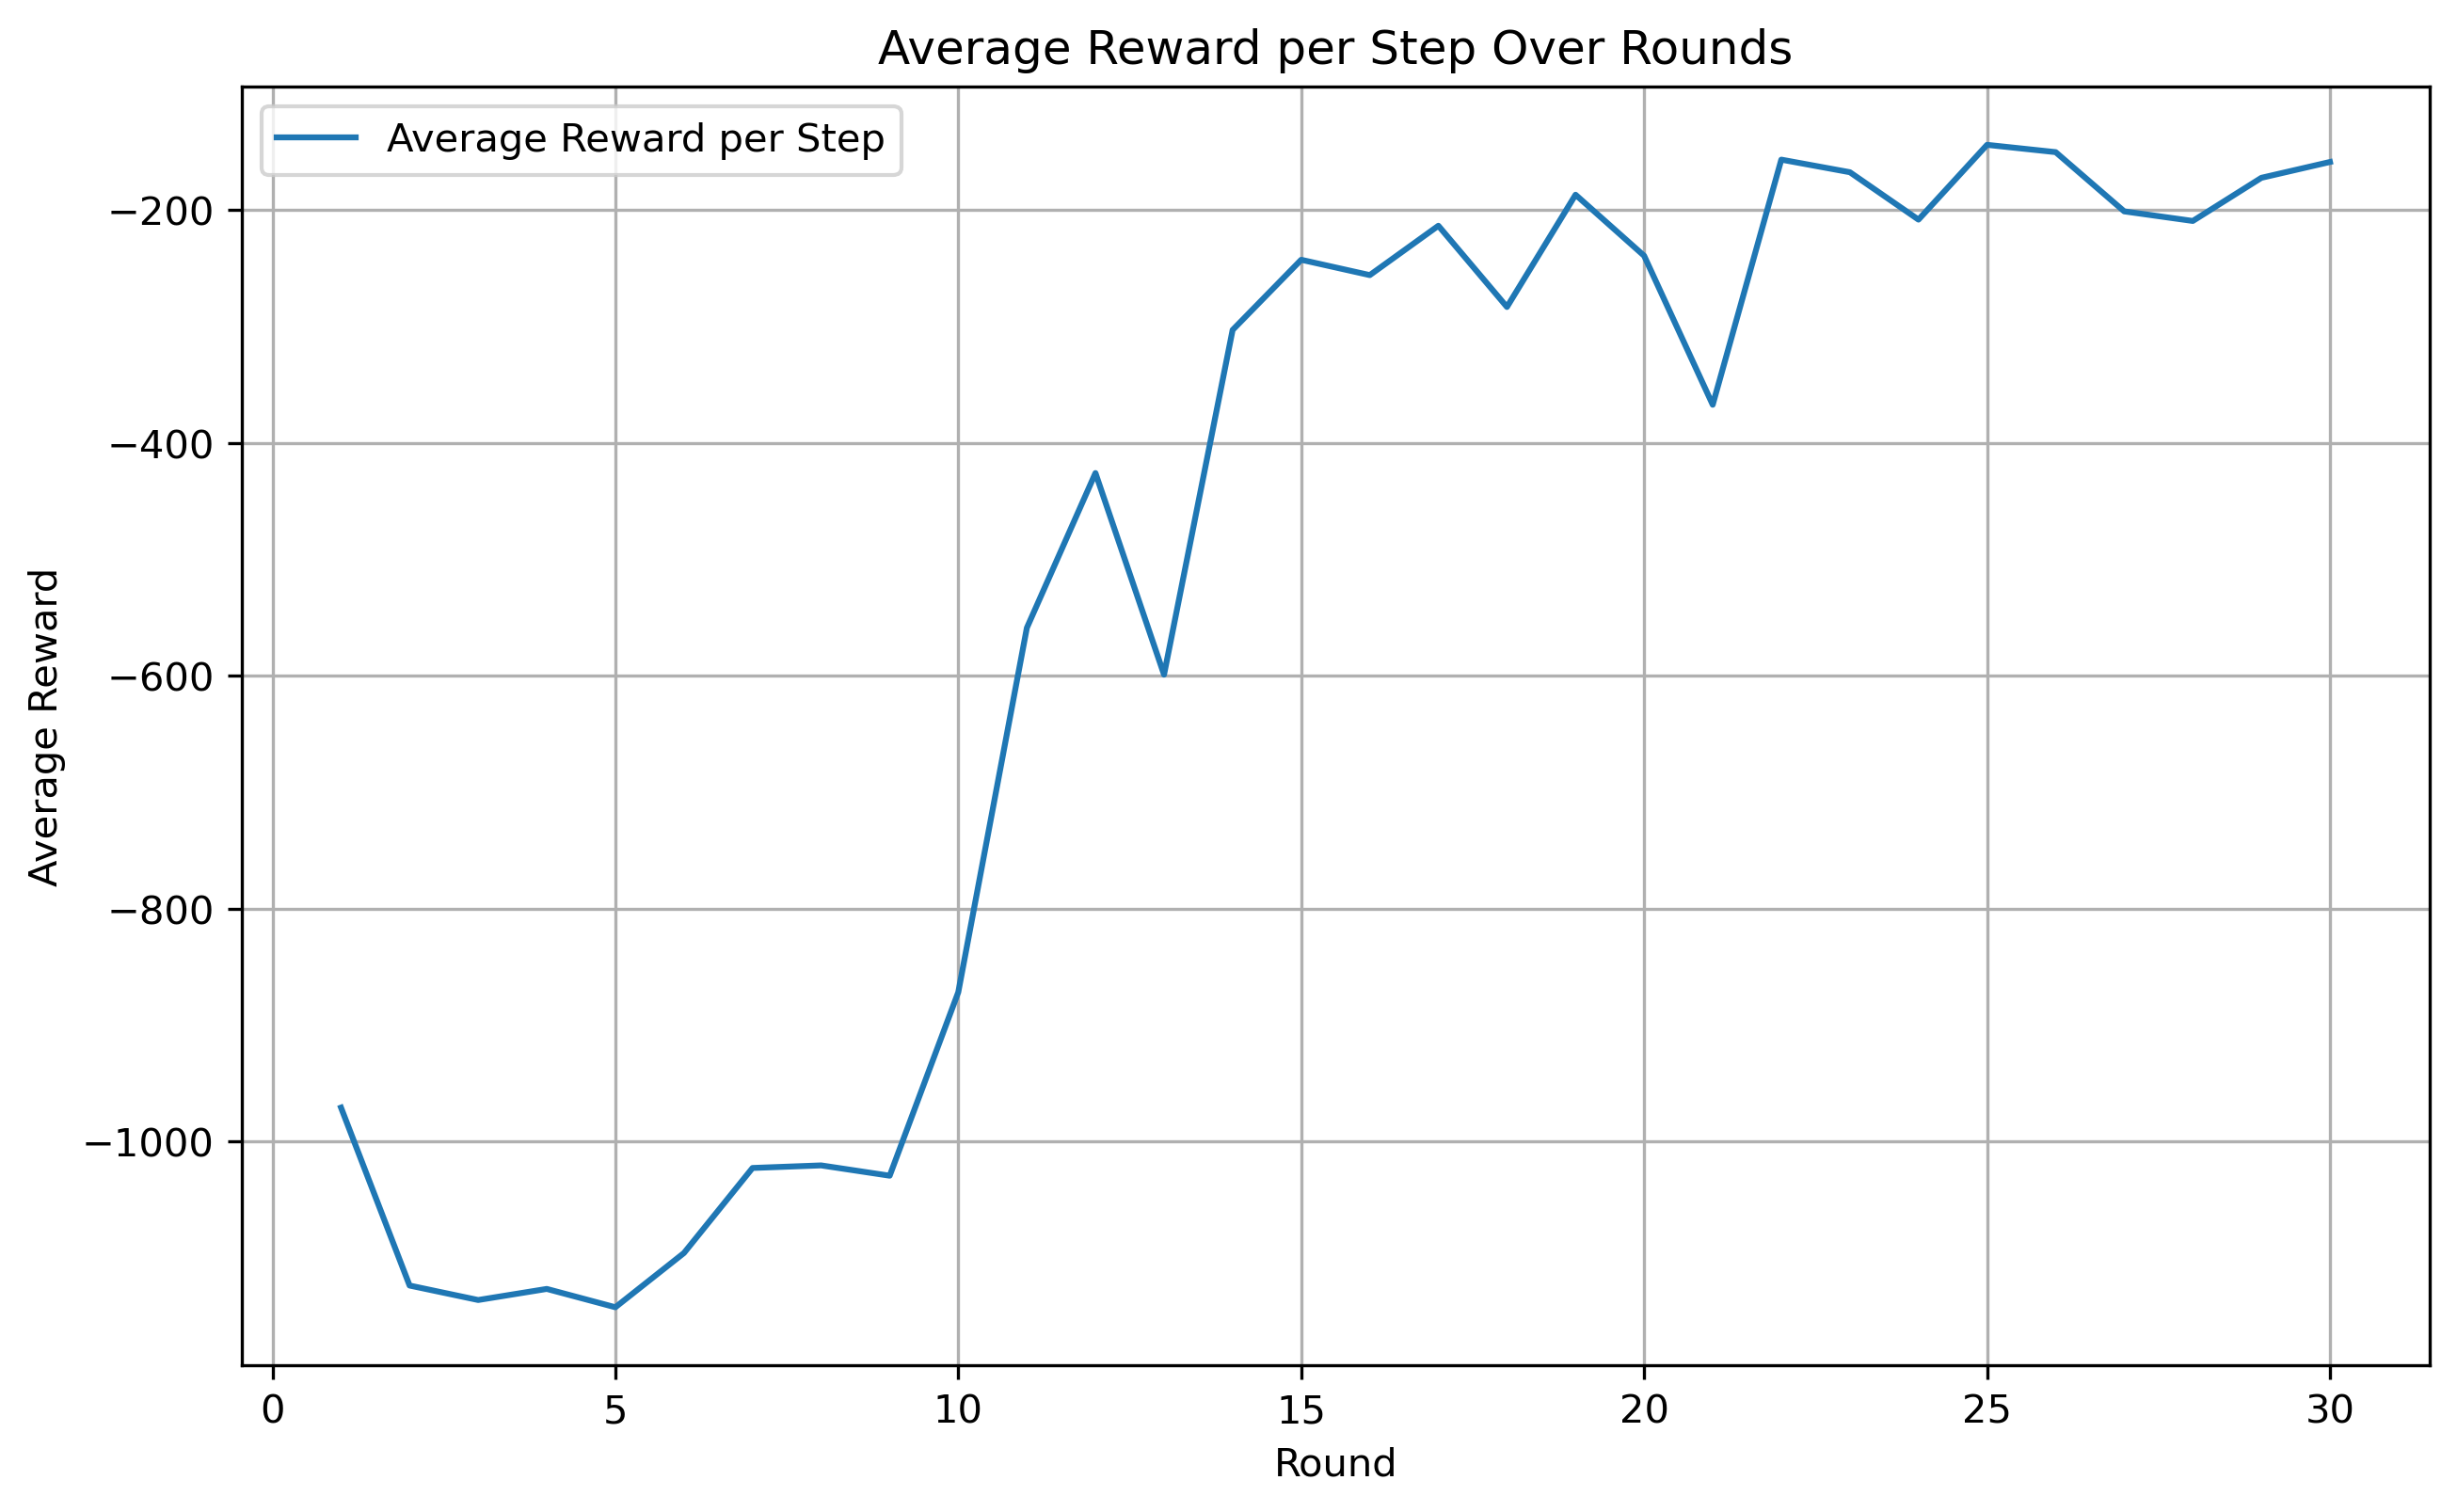

In [12]:
plot_rewards(rewards_log, 500)

In [5]:
Global_RL.env.models

[GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256

In [7]:
Global_RL.env.models

[GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256

In [42]:
MB_env.reset()

(array([ 0.25910562, -0.965849  ,  0.49215463], dtype=float32), {})

In [43]:
MB_env.obs

array([ 0.25910562, -0.965849  ,  0.49215463], dtype=float32)

In [46]:
MB_env.step(MB_env.action_space.sample())

ValueError: not enough values to unpack (expected 3, got 1)

In [47]:
MB_env.obs

array([[ 0.2085361, -0.7650793, -1.1017272]], dtype=float32)

In [5]:
obs,_ = Clients[0].env.reset()

In [6]:
obs

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [7]:
action =  Clients[0].agent.act(obs)

In [9]:
action

array([-0.33290574], dtype=float32)

In [10]:
Clients[0].model

GaussianModel(
  (fc_net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
)

In [11]:
obs_tensor = torch.tensor(obs, dtype=torch.float32)
action_tensor = torch.tensor(action, dtype=torch.float32)
input_d = torch.cat((obs_tensor, action_tensor))

In [12]:
input_d

tensor([ 0.4331,  0.9014, -0.1624, -0.3329])

In [13]:
input_d = input_d.to(device)

In [14]:
mean, logvar = Clients[0].model.forward(input_d)

In [48]:
mean, logvar[0]

(tensor([-0.0052, -0.0026,  0.6155], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([-3.5161, -2.7553, -2.9714], device='cuda:0', grad_fn=<SelectBackward0>))

In [52]:
std = torch.exp(0.5 * logvar[0])
std

tensor([0.1724, 0.2522, 0.2263], device='cuda:0', grad_fn=<ExpBackward0>)

In [53]:
eps = torch.randn_like(std)

In [54]:
eps

tensor([0.7962, 0.2781, 1.4486], device='cuda:0')

In [55]:
pred_state_change = mean + eps * std

In [56]:
pred_state_change

tensor([0.1320, 0.0675, 0.9434], device='cuda:0', grad_fn=<AddBackward0>)

In [57]:
output_np = pred_state_change.detach().cpu().numpy()

In [58]:
output_np

array([0.13200563, 0.06751756, 0.94340324], dtype=float32)

In [59]:
obs

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [60]:
obs_new = obs + output_np

In [61]:
obs_new

array([0.5650784 , 0.96887654, 0.78100085], dtype=float32)

In [27]:
import numpy as np

In [28]:
obs_clipped = np.clip(obs, Clients[0].env.observation_space.low, Clients[0].env.observation_space.high)

In [29]:
obs_clipped

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [41]:
Clients[0].agent.policy_net.predict(obs)[0]

array([-0.30735433], dtype=float32)

In [44]:
from stable_baselines3.common.evaluation import evaluate_policy

In [47]:
# mean_reward, std_reward = evaluate_policy(Global_RL, real_envs[1], n_eval_episodes=10)
mean_reward, std_reward = evaluate_policy(Global_RL, MB_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -93.15121025741101 +/- 109.2765889131137


In [55]:
from sb3_contrib import TRPO

In [59]:
TRPO_model = TRPO("MlpPolicy", env=real_envs[0], verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [61]:
TRPO_model.learn(100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -829     |
| time/              |          |
|    fps             | 520      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -847     |
| time/                     |          |
|    fps                    | 478      |
|    iterations             | 2        |
|    time_elapsed           | 8        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.715    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00696  |
|    learning_rate          | 0.001    |
|    n_updates              | 50       |
|    policy_objective       | 0.0147   |
|   

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -644     |
| time/                     |          |
|    fps                    | 473      |
|    iterations             | 13       |
|    time_elapsed           | 56       |
|    total_timesteps        | 26624    |
| train/                    |          |
|    explained_variance     | 0.928    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00833  |
|    learning_rate          | 0.001    |
|    n_updates              | 61       |
|    policy_objective       | 0.0195   |
|    std                    | 0.681    |
|    value_loss             | 334      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -604     |
| time/                     |          |
|    fps        

KeyboardInterrupt: 

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义GaussianModel
class GaussianModel(nn.Module):
    def __init__(self, obs_size, action_size, hidden_size=256, learn_logvar_bounds=False):
        super(GaussianModel, self).__init__()
        self.out_size = obs_size
        
        self.fc_net = nn.Sequential(
            nn.Linear(obs_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        
        self.mean_logvar = nn.Linear(hidden_size, obs_size * 2)
        
        self.min_logvar = nn.Parameter(
            -10 * torch.ones(1, obs_size), requires_grad=learn_logvar_bounds
        )
        self.max_logvar = nn.Parameter(
            0.5 * torch.ones(1, obs_size), requires_grad=learn_logvar_bounds
        )
        
    def forward(self, x):
        x = self.fc_net(x)
        mean_and_logvar = self.mean_logvar(x)
        mean = mean_and_logvar[..., :self.out_size]
        logvar = mean_and_logvar[..., self.out_size:]
        
        logvar = self.max_logvar - F.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
        
        # If the original input was one-dimensional, squeeze the output
        if logvar.shape[0] == 1:
            mean = mean.squeeze(0)
            logvar = logvar.squeeze(0)
        
        return mean, logvar

# 定义测试用例
def test_gaussian_model():
    obs_size = 4
    action_size = 2
    hidden_size = 256

    model = GaussianModel(obs_size, action_size, hidden_size)

    # 单个输入数据
    single_input = torch.randn(obs_size + action_size)
    
    # 批量输入数据
    batch_input = torch.randn(5, obs_size + action_size)
    
    # 前向传播
    single_mean, single_logvar = model(single_input)
    batch_mean, batch_logvar = model(batch_input)
    
    print("Single Input Mean:", single_mean)
    print("Single Input Logvar:", single_logvar)
    print("Batch Input Mean:", batch_mean)
    print("Batch Input Logvar:", batch_logvar)
    
    # 构建损失函数
    loss_fn = nn.MSELoss()
    
    # 构造目标数据
    target_mean = torch.randn(obs_size)
    target_logvar = torch.randn(obs_size)
    
    # 计算损失
    single_loss = loss_fn(single_mean, target_mean) + loss_fn(single_logvar, target_logvar)
    batch_loss = loss_fn(batch_mean, target_mean.unsqueeze(0).expand_as(batch_mean)) + \
                 loss_fn(batch_logvar, target_logvar.unsqueeze(0).expand_as(batch_logvar))
    
    print("Single Input Loss:", single_loss.item())
    print("Batch Input Loss:", batch_loss.item())

# 运行测试用例
test_gaussian_model()


Single Input Mean: tensor([ 0.3523, -0.0157, -0.2429,  0.1068], grad_fn=<SqueezeBackward1>)
Single Input Logvar: tensor([-0.5165, -0.4999, -0.4875, -0.4478], grad_fn=<SqueezeBackward1>)
Batch Input Mean: tensor([[ 0.1343,  0.0868, -0.1983,  0.0582],
        [ 0.1066, -0.1898, -0.6315,  0.0736],
        [ 0.3875,  0.1861, -0.3479,  0.0122],
        [ 0.1715,  0.0231, -0.1943,  0.1135],
        [ 0.2438, -0.0612, -0.4051,  0.0425]], grad_fn=<SliceBackward0>)
Batch Input Logvar: tensor([[-0.4949, -0.4842, -0.5894, -0.4223],
        [-0.4841, -0.3873, -0.6761, -0.3461],
        [-0.5958, -0.4917, -0.8158, -0.3497],
        [-0.4940, -0.4847, -0.5807, -0.4696],
        [-0.4818, -0.4734, -0.7298, -0.3792]], grad_fn=<AddBackward0>)
Single Input Loss: 3.6077818870544434
Batch Input Loss: 3.898193597793579
